# Replication Study: Minimum Wages and Fast-Food Employment (Card & Krueger, 1994)

**Objective:**
This notebook aims to replicate the core analysis presented in the seminal paper by David Card and Alan B. Krueger: "Minimum Wages and Employment: A Case Study of the Fast-Food Industry in New Jersey and Pennsylvania" (American Economic Review, 1994). This study is a classic example of using a natural experiment and the Difference-in-Differences (DiD) methodology to estimate causal effects.

**Background:**
*   **The Policy Change:** On April 1, 1992, the state of New Jersey (NJ) increased its minimum hourly wage from $4.25 to $5.05.
*   **The "Control" Group:** Neighboring eastern Pennsylvania (PA) did not change its minimum wage during this period, keeping it at $4.25.
*   **The Data:** Card and Krueger collected data from approximately 410 fast-food restaurants (Burger King, KFC, Roy Rogers, Wendy's) in NJ and eastern PA both *before* the wage increase (February-March 1992) and *after* the increase (November-December 1992).

**Research Question:**
What is the effect of a minimum wage increase on employment levels in the fast-food industry? The standard competitive labor market model predicts that an increase in the minimum wage (if binding) should lead to a decrease in employment. Card and Krueger tested this prediction.

**Methodology: Difference-in-Differences (DiD)**
The DiD strategy compares the change in the outcome variable (employment) in the "treatment" group (NJ) before and after the policy change to the change in the outcome variable in the "control" group (PA) over the same time period.

*   **Treatment Group:** New Jersey restaurants (received the minimum wage increase).
*   **Control Group:** Pennsylvania restaurants (did not receive the increase).
*   **Outcome Variable:** Full-Time Equivalent (FTE) employment.
*   **DiD Estimate =** (Avg Employment<sub>NJ, After</sub> - Avg Employment<sub>NJ, Before</sub>) - (Avg Employment<sub>PA, After</sub> - Avg Employment<sub>PA, Before</sub>)

**Key Identifying Assumption: Parallel Trends**
The core assumption of DiD is that, in the *absence* of the minimum wage increase in NJ, the employment trends in NJ and PA fast-food restaurants would have been parallel. The change observed in PA is used as a counterfactual for what would have happened in NJ without the policy change.

**Data Source:**
The analysis uses the publicly available dataset provided by Professor David Card.

In [21]:
# -*- coding: utf-8 -*-
# Core libraries for data manipulation, numerical operations, and file handling
import pandas as pd
import numpy as np
import os

# Libraries for data acquisition and extraction
import requests
import zipfile

# Libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for statistical modeling (regression)
import statsmodels.formula.api as smf
import statsmodels.api as sm # Used for calculating SE of difference in means later

# --- Notebook Setup ---
# Ensure plots appear directly within the notebook output
%matplotlib inline
# Set a visually appealing default style for plots
plt.style.use('seaborn-v0_8-whitegrid')
# Set a default color palette for consistency
sns.set_palette("viridis")

print("Required libraries imported successfully.")

Required libraries imported successfully.


## 1. Data Acquisition: Downloading and Extracting the Dataset

The first step is to obtain the data. We will download the compressed dataset (`njmin.zip`) directly from Professor Card's website and extract its contents into a local directory named `did_krueger_py`. The key files within the archive are `public.dat` (the raw data) and `codebook` (describes the data format and variables).

We include checks to avoid re-downloading or re-extracting if the necessary files already exist in the target directory.

In [22]:
# --- File Paths and Directory Setup ---
# Define the directory name where data will be stored
direct = "did_krueger_py"
# URL for the dataset
URL = "http://davidcard.berkeley.edu/data_sets/njmin.zip"
# Define full paths for the zip file and its expected contents
zip_destfile = os.path.join(direct, "wages.zip")
codebook_file = os.path.join(direct, "codebook")
data_file = os.path.join(direct, "public.dat")

# --- Directory Creation ---
# Create the target directory if it doesn't already exist
if not os.path.exists(direct):
    os.makedirs(direct)
    print(f"Directory created: {direct}")
else:
    print(f"Directory already exists: {direct}")

# --- Data Download ---
# Check if the zip file already exists before downloading
if not os.path.exists(zip_destfile):
    print(f"Downloading data from {URL}...")
    try:
        # Send a request to the URL
        response = requests.get(URL)
        # Raise an exception if the download fails (e.g., 404 Not Found)
        response.raise_for_status()
        # Write the downloaded content to the zip file
        with open(zip_destfile, 'wb') as f:
            f.write(response.content)
        print(f"File downloaded successfully to {zip_destfile}")

    except requests.exceptions.RequestException as e:
        # Handle potential download errors
        print(f"Error downloading file: {e}")
else:
    # Skip download if file exists
    print(f"Zip file {zip_destfile} already exists. Skipping download.")

# --- Data Extraction ---
# Check if the main data file already exists before extracting
if not os.path.exists(data_file):
    print(f"Extracting contents of {zip_destfile}...")
    try:
        # Open the zip file in read mode
        with zipfile.ZipFile(zip_destfile, 'r') as zf:
            # Extract all contents into the target directory
            zf.extractall(path=direct)
        print(f"Files extracted successfully to {direct}")
    except zipfile.BadZipFile:
        # Handle corrupted zip file errors
        print(f"Error: Downloaded file {zip_destfile} is not a valid zip file or is corrupted.")
    except FileNotFoundError:
        # Handle case where zip file wasn't downloaded
        print(f"Error: Zip file {zip_destfile} not found. Cannot extract.")
    except Exception as e:
        # Handle other potential extraction errors
        print(f"An error occurred during extraction: {e}")
else:
     # Skip extraction if data file exists
     print(f"Data file {data_file} already exists. Skipping extraction.")

Directory already exists: did_krueger_py
Zip file did_krueger_py\wages.zip already exists. Skipping download.
Data file did_krueger_py\public.dat already exists. Skipping extraction.


## 2. Data Loading: Parsing the Codebook and Reading Raw Data

The raw data file (`public.dat`) does not contain variable names (headers). These names, along with the data structure, are documented in the `codebook` file. We need to parse the `codebook` to extract the variable names first. The codebook structure requires careful parsing based on character positions.

Once we have the variable names, we can load the `public.dat` file using pandas. Since the data appears space-delimited and uses `.` to represent missing values, we configure `pd.read_csv` accordingly. We then assign the extracted names, handle potential discrepancies in column counts, and perform initial data type conversions.

In [24]:
# --- Codebook Parsing for Variable Names ---
variable_names = [] # Initialize an empty list to store names
try:
    # Open the codebook file. 'latin1' encoding is often needed for older text files
    # that might contain special characters not handled by standard 'utf-8'.
    with open(codebook_file, 'r', encoding='latin1') as f:
        codebook_lines = f.readlines()
    print("Codebook read successfully.")

    # Extract variable names based on observed structure in codebook lines 8-59
    # (Python index 7 to 58), skipping specified intermediate description lines.
    # Indices to skip within the 7:58 slice (0-based): 4, 5, 12, 13, 31, 32
    indices_to_remove_within_slice = {4, 5, 12, 13, 31, 32}
    codebook_relevant_lines = codebook_lines[7:59] # Slice lines 8-59

    for i, line in enumerate(codebook_relevant_lines):
        # Skip the lines specified
        if i not in indices_to_remove_within_slice:
            # Extract name from the first 13 characters, remove whitespace, convert to lowercase
            var_name = line[:13].strip().lower()
            # Ensure we don't add empty strings if a line was improperly formatted
            if var_name:
                 variable_names.append(var_name)

    print(f"Extracted {len(variable_names)} variable names.")
    if variable_names:
        print("First 10 variable names:", variable_names[:10])
    else:
        # This would indicate a problem with the parsing logic or codebook format
        print("Warning: No variable names were extracted. Check codebook parsing logic.")

except FileNotFoundError:
    print(f"Error: Codebook file not found at {codebook_file}. Cannot extract variable names.")
except Exception as e:
    print(f"An error occurred reading or parsing the codebook: {e}")

# --- Data Loading and Initial Cleaning ---
dataset = pd.DataFrame() # Initialize an empty DataFrame in case loading fails

# Proceed only if variable names were successfully extracted
if variable_names:
    try:
        # Load the dataset:
        # - delim_whitespace=True handles space-separated values
        # - header=None specifies that the file has no header row
        # - na_values=["."] tells pandas to treat '.' characters as missing (NaN)
        dataset_raw = pd.read_csv(data_file, delim_whitespace=True, header=None, na_values=["."])
        print(f"\nRaw data loaded successfully with shape: {dataset_raw.shape}")

        # Verify column count consistency and handle potential extra empty columns
        expected_cols = len(variable_names)
        actual_cols = dataset_raw.shape[1]

        if actual_cols > expected_cols:
             print(f"Data has {actual_cols} columns, but {expected_cols} names were extracted.")
             # Check if the extra columns are completely empty or just NaN
             extra_cols_data = dataset_raw.iloc[:, expected_cols:]
             if extra_cols_data.isnull().all().all():
                  print(f"Dropping {actual_cols - expected_cols} trailing empty/NA column(s).")
                  dataset_raw = dataset_raw.iloc[:, :expected_cols]
             else:
                  # This case is less likely but handled defensively
                  print(f"Warning: Trailing columns contain data, but are being dropped to match extracted variable names.")
                  dataset_raw = dataset_raw.iloc[:, :expected_cols]
        elif actual_cols < expected_cols:
             print(f"Error: Data has {actual_cols} columns, but {expected_cols} names were extracted. Aborting.")
             variable_names = [] # Prevent further processing

        # Assign column names if counts match
        if dataset_raw.shape[1] == expected_cols:
            dataset_raw.columns = variable_names
            print("Column names assigned successfully.")

            # --- Data Type Conversion ---
            # Store the 'sheet' column (store ID) separately before converting others
            # Convert 'sheet' to string type for identification purposes
            sheet_col = dataset_raw['sheet'].astype(str)

            # Convert all other columns to numeric type.
            # 'errors='coerce'' will turn any value that cannot be converted into NaN (Not a Number).
            dataset = dataset_raw.drop(columns=['sheet']).apply(pd.to_numeric, errors='coerce')

            # Re-insert the 'sheet' column at the beginning of the DataFrame
            dataset.insert(0, 'sheet', sheet_col)

            print("\nData types converted: 'sheet' to string, others to numeric (with errors as NaN).")
            print("\nDataset Structure (Info):")
            dataset.info()
            print("\nFirst 5 Rows of Loaded Dataset (Head):")
            print(dataset.head())

        else:
            # Handle the case where column count mismatch persists
            print(f"Error: Column count mismatch after attempting cleanup ({dataset_raw.shape[1]} vs {expected_cols}). Cannot proceed.")
            dataset = pd.DataFrame() # Ensure dataset is empty

    except FileNotFoundError:
        print(f"Error: Data file not found at {data_file}.")
        dataset = pd.DataFrame() # Ensure dataset is empty
    except Exception as e:
        print(f"An error occurred loading or processing the data file: {e}")
        dataset = pd.DataFrame() # Ensure dataset is empty
else:
    print("\nCannot load data because variable names were not extracted.")

Codebook read successfully.
Extracted 46 variable names.
First 10 variable names: ['sheet', 'chain', 'co_owned', 'state', 'southj', 'centralj', 'northj', 'pa1', 'pa2', 'shore']

Raw data loaded successfully with shape: (410, 46)
Column names assigned successfully.

Data types converted: 'sheet' to string, others to numeric (with errors as NaN).

Dataset Structure (Info):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 46 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sheet     410 non-null    object 
 1   chain     410 non-null    int64  
 2   co_owned  410 non-null    int64  
 3   state     410 non-null    int64  
 4   southj    410 non-null    int64  
 5   centralj  410 non-null    int64  
 6   northj    410 non-null    int64  
 7   pa1       410 non-null    int64  
 8   pa2       410 non-null    int64  
 9   shore     410 non-null    int64  
 10  ncalls    410 non-null    int64  
 11  empft    

C:\Users\yirsu\AppData\Local\Temp\ipykernel_4580\793259616.py:47: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataset_raw = pd.read_csv(data_file, delim_whitespace=True, header=None, na_values=["."])


## 3. Feature Engineering: Calculating Full-Time Equivalent (FTE) Employment

The primary outcome variable in the study is employment. Simply counting employees can be misleading because of the mix of full-time and part-time workers. Card and Krueger addressed this by calculating **Full-Time Equivalent (FTE)** employment.

The formula used is:
`FTE = (Number of full-time employees) + (Number of managers) + 0.5 * (Number of part-time employees)`

We will calculate this FTE measure for each restaurant *before* the wage change (`fte_before`) using the wave 1 employment variables (`empft`, `nmgrs`, `emppt`) and *after* the wage change (`fte_after`) using the wave 2 variables (`empft2`, `nmgrs2`, `emppt2`).

We create a new DataFrame `data1` containing these FTE variables and other key variables needed for the analysis.

In [25]:
# Proceed only if the dataset was loaded successfully
if not dataset.empty:
    # --- Select Relevant Columns ---
    # Create a new DataFrame 'data1' with variables needed for analysis.
    # Using .copy() prevents SettingWithCopyWarning later.
    relevant_columns = [
        'sheet', # Store identifier
        'state', # 0=PA, 1=NJ (Treatment indicator)
        'chain', # Restaurant chain (potential control variable)
        'co_owned', # Company owned vs. franchisee (potential control)
        # Location dummies (could be used as controls, not used in basic model)
        'southj', 'centralj', 'northj', 'pa1', 'pa2',
        # Wave 1 (Before) variables
        'empft', 'emppt', 'nmgrs', 'wage_st', 'hrsopen',
        # Wave 2 (After) variables
        'empft2', 'emppt2', 'nmgrs2', 'wage_st2', 'hrsopen2',
        # Status of second interview (important for sample definition)
        'status2'
    ]
    data1 = dataset[relevant_columns].copy()

    # --- Clean State Indicator ---
    # Ensure 'state' is represented as strings '0' and '1' for clarity in grouping/modeling
    # First, handle potential NaN values if any exist, then convert type
    data1['state'] = data1['state'].dropna().astype(int).astype(str)

    # --- Calculate FTE Variables ---
    # FTE Before = FullTime_1 + Managers_1 + 0.5 * PartTime_1
    data1['fte_before'] = data1['empft'] + data1['nmgrs'] + data1['emppt'] * 0.5
    # FTE After = FullTime_2 + Managers_2 + 0.5 * PartTime_2
    data1['fte_after'] = data1['empft2'] + data1['nmgrs2'] + data1['emppt2'] * 0.5

    print("FTE 'before' and 'after' variables calculated.")
    print("Displaying relevant columns from the first 5 rows:")
    print(data1[['sheet', 'state', 'empft', 'emppt', 'nmgrs', 'fte_before',
                 'empft2', 'emppt2', 'nmgrs2', 'fte_after']].head())

    # --- Examine Status Variable ---
    # Understand the different outcomes of the second interview wave
    # Codes: 0=refused, 1=answered, 2=closed renovations, 3=closed permanently,
    # 4=closed highway construction, 5=closed mall fire
    print("\nUnique values found in 'status2' column:", data1['status2'].unique())
    print("Value counts for 'status2':")
    print(data1['status2'].value_counts())

else:
    print("\nSkipping Feature Engineering step as the initial dataset is empty or failed to load.")

FTE 'before' and 'after' variables calculated.
Displaying relevant columns from the first 5 rows:
  sheet state  empft  emppt  nmgrs  fte_before  empft2  emppt2  nmgrs2  \
0    46     0   30.0   15.0    3.0       40.50     3.5    35.0     3.0   
1    49     0    6.5    6.5    4.0       13.75     0.0    15.0     4.0   
2   506     0    3.0    7.0    2.0        8.50     3.0     7.0     4.0   
3    56     0   20.0   20.0    4.0       34.00     0.0    36.0     2.0   
4    61     0    6.0   26.0    5.0       24.00    28.0     3.0     6.0   

   fte_after  
0       24.0  
1       11.5  
2       10.5  
3       20.0  
4       35.5  

Unique values found in 'status2' column: [1 3 4 2 0 5]
Value counts for 'status2':
status2
1    399
3      6
2      2
4      1
0      1
5      1
Name: count, dtype: int64


## 4. Exploratory Data Analysis: Descriptive Statistics

Before proceeding to the core DiD analysis, it's useful to examine the characteristics of the sample. We calculate descriptive statistics (count, mean, standard deviation, min, max) for key variables, including the raw employment counts and the calculated FTE measures. This provides an overview of the typical restaurant size, wages, and hours in the sample.

In [28]:
# Proceed only if data1 was created successfully
if 'data1' in locals() and not data1.empty:
    # --- Define Variables for Summary ---
    # List of columns for which we want descriptive statistics
    cols_for_desc_stats = [
        'state', 'chain', 'co_owned',
        'empft', 'emppt', 'nmgrs', 'fte_before', 'wage_st', 'hrsopen',
        'empft2', 'emppt2', 'nmgrs2', 'fte_after', 'wage_st2', 'hrsopen2',
        'status2'
    ]
    # Ensure only columns present in data1 are included
    cols_for_desc_stats = [col for col in cols_for_desc_stats if col in data1.columns]

    # --- Calculate Descriptive Statistics ---
    # Use pandas .describe() method for numerical summaries
    # .transpose() makes variables the rows for easier reading
    desc_stats = data1[cols_for_desc_stats].describe().transpose()

    # --- Format the Output Table ---
    # Select only the desired statistics
    desc_stats_formatted = desc_stats[['count', 'mean', 'std', 'min', 'max']].copy()
    # Rename columns for better readability
    desc_stats_formatted.rename(columns={
        'count': 'Valid N', # Number of non-missing observations
        'mean': 'Mean',
        'std': 'Std. Dev.',
        'min': 'Min',
        'max': 'Max'
    }, inplace=True)
    # Convert 'Valid N' to integer type
    desc_stats_formatted['Valid N'] = desc_stats_formatted['Valid N'].astype(int)

    print("\nDescriptive Statistics for Key Variables:")
    # Display the formatted table, showing precision to 2 decimal places
    print(desc_stats_formatted.round(2))

else:
    print("\nSkipping Descriptive Statistics as the 'data1' DataFrame is not available.")


Descriptive Statistics for Key Variables:
            Valid N   Mean  Std. Dev.   Min    Max
chain           410   2.12       1.11  1.00   4.00
co_owned        410   0.34       0.48  0.00   1.00
empft           404   8.20       8.62  0.00  60.00
emppt           406  18.83      10.08  0.00  60.00
nmgrs           404   3.42       1.02  1.00  10.00
fte_before      398  21.00       9.75  5.00  85.00
wage_st         390   4.62       0.35  4.25   5.75
hrsopen         410  14.44       2.81  7.00  24.00
empft2          398   8.28       7.97  0.00  40.00
emppt2          400  18.68      10.70  0.00  60.00
nmgrs2          404   3.48       1.14  0.00   8.00
fte_after       396  21.05       9.09  0.00  60.50
wage_st2        389   5.00       0.25  4.25   6.25
hrsopen2        399  14.47       2.75  8.00  24.00
status2         410   1.05       0.35  0.00   5.00


## 5. Visualization: Distribution of Starting Wages Before and After Policy Change

A crucial piece of evidence for the DiD setup is showing that the minimum wage increase in NJ actually *affected* the wages paid by the restaurants (i.e., the policy had "bite"). We visualize this by plotting histograms of the starting wage (`wage_st` before, `wage_st2` after) for NJ and PA separately.

We expect to see:
*   **Before (Feb 1992):** Both NJ and PA distributions might cluster around the old minimum wage ($4.25) and potentially other wage points.
*   **After (Nov 1992):** The PA distribution should look similar to its "before" state. The NJ distribution should show a significant shift, with a large spike at the new minimum wage ($5.05) and fewer stores paying wages between $4.25 and $5.05.

We will bin the wages into categories (e.g., $0.10 increments) and plot the *percentage* of stores in each state falling into each wage bin.


--- Visualizing Starting Wage Distributions ---
Defined 15 bin edges and 14 labels for wage distributions.


C:\Users\yirsu\AppData\Local\Temp\ipykernel_4580\3092919669.py:39: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_data_before, x='category', y='percent', hue='state', ci=None) # ci=None suppresses error bars for simple percentages


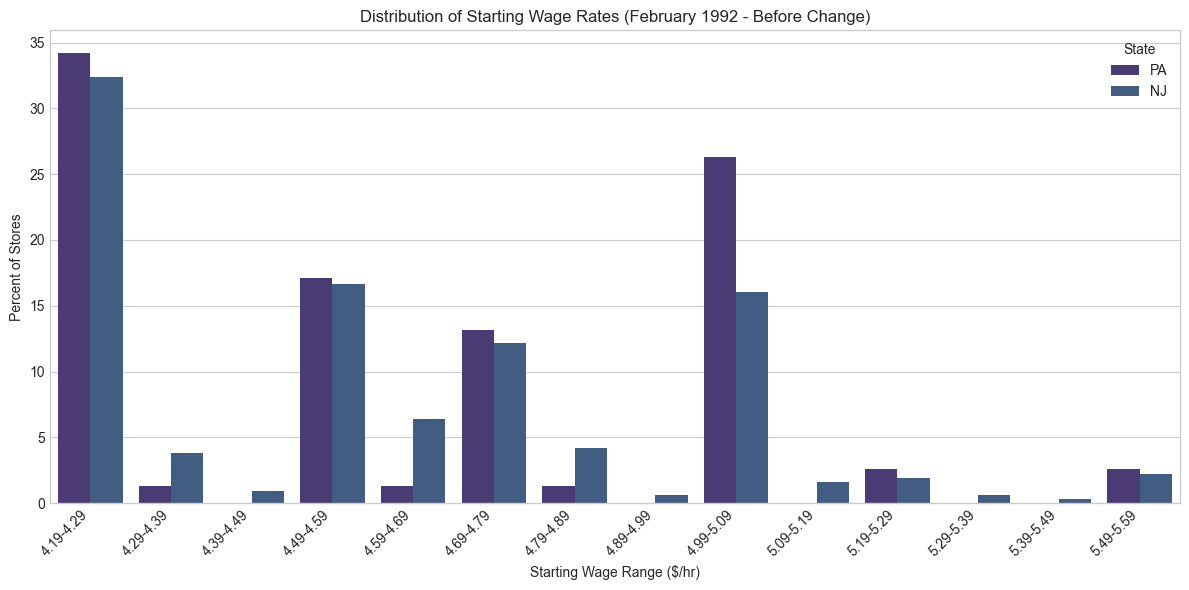

C:\Users\yirsu\AppData\Local\Temp\ipykernel_4580\3092919669.py:65: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=plot_data_after, x='category', y='percent', hue='state', ci=None)


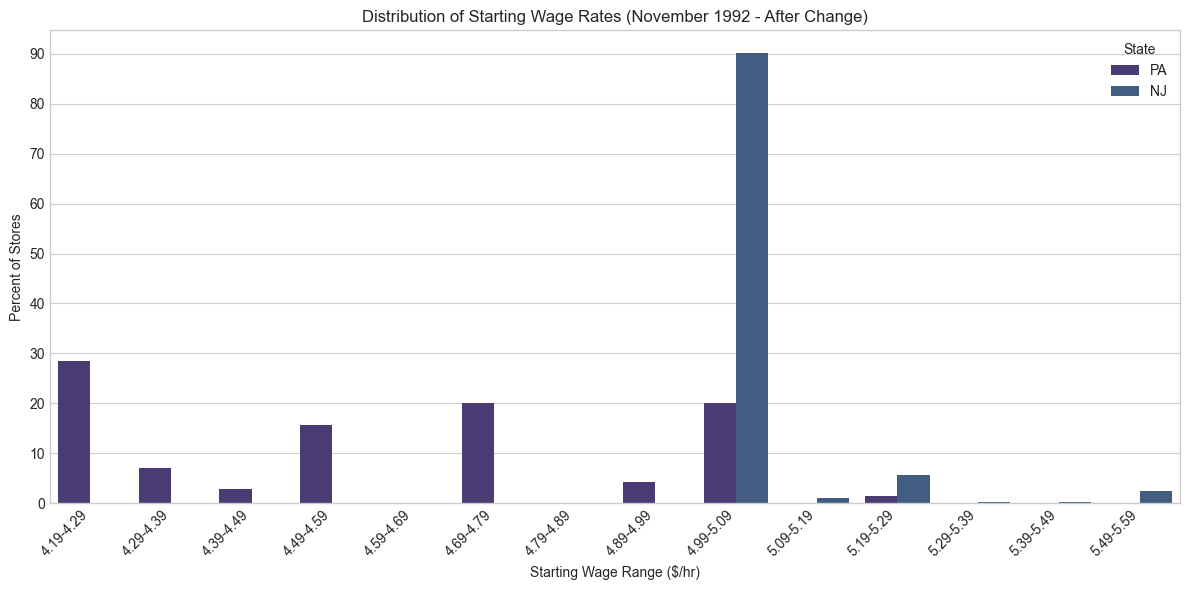

In [ ]:
if not data1.empty:
    # Select columns for descriptive statistics
    cols_for_desc = [
        'co_owned', 'southj', 'centralj', 'northj', 'pa1', 'pa2',
        'wage_st', 'wage_st2', 'hrsopen', 'hrsopen2',
        'empft', 'emppt', 'nmgrs', # Before counts
        'empft2','emppt2', 'nmgrs2',# After counts
        'chain', 'status2',
        'fte_before', 'fte_after' # Calculated FTE
    ]

    # Use pandas describe and select relevant stats
    desc_stats = data1[cols_for_desc].describe().transpose()

    # Select and rename columns to closely match R output
    desc_stats_formatted = desc_stats[['count', 'mean', 'std', 'min', 'max']].copy()
    desc_stats_formatted.rename(columns={
        'count': 'Valid N',
        'mean': 'Mean',
        'std': 'Std. dev.',
        'min': 'Min',
        'max': 'Max'
    }, inplace=True)

    # Ensure 'Valid N' is integer
    desc_stats_formatted['Valid N'] = desc_stats_formatted['Valid N'].astype(int)

    print("\nDescriptive Statistics (Total Sample):")
    print(desc_stats_formatted)

else:
    print("\nSkipping Descriptive Statistics as data1 is empty.")

## 6. Difference-in-Differences Estimation: Group Means Comparison

This section calculates the DiD estimate by comparing the average changes in FTE employment between the two states. This mirrors the structure of Table 2 in the Card and Krueger paper.

We calculate:
1.  Average FTE employment *before* the change in each state.
2.  Average FTE employment *after* the change in each state.
3.  The *change* in average FTE employment within each state (After - Before). For this change calculation, it's crucial to use the **balanced panel** – only those stores with valid FTE data in *both* wave 1 and wave 2 – to ensure we are comparing the same set of stores over time.
4.  The difference between NJ and PA for each of these values. The difference in the *changes* (Row 3, NJ - PA) is the simple DiD estimate.

We also compute standard errors (SE) for the means and for the *change* within each state (using the balanced panel data). The SE for the final DiD estimate based on these means is also calculated.

In [30]:
# Proceed only if data1 is available
if 'data1' in locals() and not data1.empty:
    print("\n--- Calculating Difference-in-Differences using Group Means (Table 2 Replication) ---")

    # --- Calculations using ALL available data for initial means ---
    # Group by state and calculate mean, variance, and count for FTE before/after
    summary_stats_all = data1.groupby('state').agg(
        mean_before=('fte_before', 'mean'),
        mean_after=('fte_after', 'mean'),
        var_before=('fte_before', 'var'),
        var_after=('fte_after', 'var'),
        n_before=('fte_before', 'count'),
        n_after=('fte_after', 'count')
    ).reset_index()

    # Calculate Standard Errors (SE) for the means using all available data
    summary_stats_all['se_mean_before'] = np.sqrt(summary_stats_all['var_before'] / summary_stats_all['n_before'])
    summary_stats_all['se_mean_after'] = np.sqrt(summary_stats_all['var_after'] / summary_stats_all['n_after'])
    summary_stats_all['state_name'] = summary_stats_all['state'].map({'0': 'PA', '1': 'NJ'})
    print("\nMeans based on all available data per wave:")
    print(summary_stats_all[['state_name', 'mean_before', 'se_mean_before', 'n_before', 'mean_after', 'se_mean_after', 'n_after']].round(3))


    # --- Calculations using the BALANCED PANEL for changes ---
    # Create balanced panel: Stores with non-missing FTE in BOTH waves
    balanced_panel = data1.dropna(subset=['fte_before', 'fte_after']).copy()
    print(f"\nNumber of stores in balanced panel: {len(balanced_panel)}")

    # Calculate stats using only the balanced panel
    balanced_stats = balanced_panel.groupby('state').agg(
        mean_before_bal=('fte_before', 'mean'),
        mean_after_bal=('fte_after', 'mean'),
        var_before_bal=('fte_before', 'var'),
        var_after_bal=('fte_after', 'var'),
        n_balanced=('sheet', 'count') # Count stores in balanced sample
    ).reset_index()

    # Calculate the CHANGE in means for the balanced panel
    balanced_stats['change_mean_fte_balanced'] = balanced_stats['mean_after_bal'] - balanced_stats['mean_before_bal']

    # Calculate covariance between FTE_before and FTE_after within the balanced panel for SE calculation
    cov_pa = balanced_panel[balanced_panel['state']=='0'][['fte_before', 'fte_after']].cov().iloc[0,1]
    cov_nj = balanced_panel[balanced_panel['state']=='1'][['fte_before', 'fte_after']].cov().iloc[0,1]

    # Calculate Variance of the CHANGE in FTE for the balanced panel
    # Var(After - Before) = Var(After) + Var(Before) - 2*Cov(After, Before)
    balanced_stats['var_change_bal'] = (balanced_stats['var_after_bal'] + balanced_stats['var_before_bal'] - 2 * balanced_stats['state'].map({'0': cov_pa, '1': cov_nj}))

    # Calculate Standard Error (SE) of the CHANGE in mean FTE for the balanced panel
    # SE(change) = sqrt( Var(change) / n )
    balanced_stats['se_change_balanced'] = np.sqrt(balanced_stats['var_change_bal'] / balanced_stats['n_balanced'])
    balanced_stats['state_name'] = balanced_stats['state'].map({'0': 'PA', '1': 'NJ'})

    print("\nChange in means based on balanced panel:")
    print(balanced_stats[['state_name', 'change_mean_fte_balanced', 'se_change_balanced', 'n_balanced']].round(3))

    # --- Assemble the Final Table ---
    # Use means from all data, but change from balanced data, mirroring paper's Table 2 structure
    final_table_structure = {
        'Variable': ['Mean FTE (Before)', 'SE (Before)', 'Mean FTE (After)', 'SE (After)', 'Change in Mean FTE (Balanced)', 'SE of Change (Balanced)'],
        'PA': [
            summary_stats_all.loc[summary_stats_all['state']=='0', 'mean_before'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='0', 'se_mean_before'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='0', 'mean_after'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='0', 'se_mean_after'].iloc[0],
            balanced_stats.loc[balanced_stats['state']=='0', 'change_mean_fte_balanced'].iloc[0],
            balanced_stats.loc[balanced_stats['state']=='0', 'se_change_balanced'].iloc[0]
        ],
        'NJ': [
            summary_stats_all.loc[summary_stats_all['state']=='1', 'mean_before'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='1', 'se_mean_before'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='1', 'mean_after'].iloc[0],
            summary_stats_all.loc[summary_stats_all['state']=='1', 'se_mean_after'].iloc[0],
            balanced_stats.loc[balanced_stats['state']=='1', 'change_mean_fte_balanced'].iloc[0],
            balanced_stats.loc[balanced_stats['state']=='1', 'se_change_balanced'].iloc[0]
        ]
    }
    final_table_df = pd.DataFrame(final_table_structure)
    final_table_df['Difference (NJ - PA)'] = final_table_df['NJ'] - final_table_df['PA']

    # Calculate the DiD estimate and its SE from the balanced means changes
    did_estimate_means = final_table_df.loc[final_table_df['Variable'] == 'Change in Mean FTE (Balanced)', 'Difference (NJ - PA)'].iloc[0]
    se_change_pa = final_table_df.loc[final_table_df['Variable'] == 'SE of Change (Balanced)', 'PA'].iloc[0]
    se_change_nj = final_table_df.loc[final_table_df['Variable'] == 'SE of Change (Balanced)', 'NJ'].iloc[0]
    # SE[DiD] = sqrt( SE[change_NJ]^2 + SE[change_PA]^2 ) assuming independence between states
    se_did_means = np.sqrt(se_change_nj**2 + se_change_pa**2)

    # Add DiD estimate and SE as summary rows
    did_row_df = pd.DataFrame({
        'Variable': ['DiD Estimate (Balanced Means)', 'SE of DiD Estimate (Balanced Means)'],
        'PA': [np.nan, np.nan],
        'NJ': [np.nan, np.nan],
        'Difference (NJ - PA)': [did_estimate_means, se_did_means]
    })

    # Combine the main table with the summary rows
    output_table = pd.concat([final_table_df, did_row_df], ignore_index=True)

    print("\n--- Summary Table: FTE Employment Before and After ---")
    print(output_table.round(3))

    # Print sample sizes used for the balanced change calculation
    print("\nSample Sizes (Balanced Panel Used for Change Calculation):")
    print(balanced_stats[['state_name', 'n_balanced']].set_index('state_name'))

else:
    print("\nSkipping Difference-in-Differences (Means) calculation as 'data1' DataFrame is not available.")


--- Calculating Difference-in-Differences using Group Means (Table 2 Replication) ---

Means based on all available data per wave:
  state_name  mean_before  se_mean_before  n_before  mean_after  \
0         PA       23.331           1.351        77      21.166   
1         NJ       20.439           0.508       321      21.027   

   se_mean_after  n_after  
0          0.943       77  
1          0.520      319  

Number of stores in balanced panel: 384

Change in means based on balanced panel:
  state_name  change_mean_fte_balanced  se_change_balanced  n_balanced
0         PA                    -2.283               1.253          75
1         NJ                     0.467               0.481         309

--- Summary Table: FTE Employment Before and After ---
                              Variable      PA      NJ  Difference (NJ - PA)
0                    Mean FTE (Before)  23.331  20.439                -2.892
1                          SE (Before)   1.351   0.508                -0.843

## 7. Difference-in-Differences Estimation: Regression Approach

While the comparison of group means provides a straightforward DiD estimate, a regression framework offers several advantages:
1.  **Control Variables:** It allows us to include control variables (e.g., restaurant chain, ownership status) to account for potential pre-existing differences between restaurants that might be correlated with employment changes.
2.  **Standard Errors:** It directly estimates the standard error of the DiD coefficient, facilitating statistical inference.

The regression model estimates the *change* in FTE employment (`fte_after - fte_before`) as a function of being in the treatment state (NJ) and other control variables.

The model specification is:
`ΔFTEᵢ = β₀ + β₁ * StateNJᵢ + Controlsᵢ'γ + εᵢ`

Where:
*   `ΔFTEᵢ` is the change in FTE for restaurant `i`.
*   `StateNJᵢ` is an indicator variable (dummy) = 1 if the restaurant is in NJ, 0 if in PA.
*   `Controlsᵢ` is a vector of control variables (e.g., dummies for chain, company ownership).
*   `β₁` is the coefficient of interest: the DiD estimate, representing the average difference in FTE change between NJ and PA, *after* accounting for the control variables.
*   `β₀` is the intercept (average change for the reference group - PA stores of the reference chain).
*   `γ` is a vector of coefficients for the control variables.
*   `εᵢ` is the error term.

**Sample Definition:** Following the paper (e.g., Table 3), the regression sample typically includes stores present in both waves (balanced panel) for which wage data is available *or* stores that permanently closed (`status2 == 3`).

In [19]:
if not data1.empty:
    print("\n--- Calculating Average Employment Changes (Table 2 Replication) ---")

    # Calculate means, counts, variances, and SEs for FTE before and after, grouped by state
    summary_stats = data1.groupby('state').agg(
        mean_before=('fte_before', 'mean'),
        mean_after=('fte_after', 'mean'),
        var_before=('fte_before', 'var'),
        var_after=('fte_after', 'var'),
        n_before=('fte_before', 'count'), # count() ignores NaNs
        n_after=('fte_after', 'count')
    ).reset_index()

    # Calculate Standard Errors (SE) for the means
    summary_stats['se_mean_before'] = np.sqrt(summary_stats['var_before'] / summary_stats['n_before'])
    summary_stats['se_mean_after'] = np.sqrt(summary_stats['var_after'] / summary_stats['n_after'])

    # Calculate change in mean FTE using all available data
    summary_stats['change_mean_fte'] = summary_stats['mean_after'] - summary_stats['mean_before']

    # Map state codes to names for clarity
    summary_stats['state_name'] = summary_stats['state'].map({'0': 'PA', '1': 'NJ'})

    # --- Balanced sample calculation (stores with non-missing FTE in both waves) ---
    balanced_data = data1.dropna(subset=['fte_before', 'fte_after']).copy() # Crucial filter
    balanced_stats = balanced_data.groupby('state').agg(
        mean_before_bal=('fte_before', 'mean'),
        mean_after_bal=('fte_after', 'mean'),
        var_before_bal=('fte_before', 'var'),
        var_after_bal=('fte_after', 'var'),
        n_balanced=('sheet', 'count') # Count stores in balanced sample
    ).reset_index()

    # Calculate change for the balanced sample
    balanced_stats['change_mean_fte_balanced'] = balanced_stats['mean_after_bal'] - balanced_stats['mean_before_bal']

     # Calculate covariance for SE of the change
    cov_pa = balanced_data[balanced_data['state']=='0'][['fte_before', 'fte_after']].cov().iloc[0,1]
    cov_nj = balanced_data[balanced_data['state']=='1'][['fte_before', 'fte_after']].cov().iloc[0,1]

    # Variance and SE of the *change* within each state (balanced sample)
    balanced_stats['var_change_bal'] = (balanced_stats['var_before_bal'] + balanced_stats['var_after_bal'] - 2 * balanced_stats['state'].map({'0': cov_pa, '1': cov_nj}))
    balanced_stats['se_change_balanced'] = np.sqrt(balanced_stats['var_change_bal'] / balanced_stats['n_balanced'])


    balanced_stats['state_name'] = balanced_stats['state'].map({'0': 'PA', '1': 'NJ'})

    # --- Combine results into a table structure ---
    # Select columns needed for the final table display
    table_data = summary_stats[['state_name', 'mean_before', 'mean_after', 'se_mean_before', 'se_mean_after']].copy()
    # Merge the balanced change and its SE
    table_data = pd.merge(table_data, balanced_stats[['state_name', 'change_mean_fte_balanced', 'se_change_balanced', 'n_balanced']],
                          on='state_name', how='left')

    # Set state name as index for transposition
    table_data.set_index('state_name', inplace=True)

    # Transpose the table
    transposed_table = table_data[['mean_before', 'se_mean_before', 'mean_after', 'se_mean_after', 'change_mean_fte_balanced', 'se_change_balanced']].transpose()

    # Rename index for clarity
    transposed_table.index = ['Mean FTE (Before)', 'SE (Before)', 'Mean FTE (After)', 'SE (After)', 'Change in Mean FTE (Balanced)', 'SE of Change (Balanced)']

    # Calculate the NJ - PA difference column
    transposed_table['Difference (NJ - PA)'] = transposed_table['NJ'] - transposed_table['PA']

    # --- Calculate the DiD estimate and its SE (using balanced sample changes) ---
    did_estimate_means = transposed_table.loc['Change in Mean FTE (Balanced)', 'Difference (NJ - PA)']

    # SE[DiD] = sqrt( SE[change_NJ]^2 + SE[change_PA]^2 ) assuming independence of changes between states
    se_change_pa = transposed_table.loc['SE of Change (Balanced)', 'PA']
    se_change_nj = transposed_table.loc['SE of Change (Balanced)', 'NJ']
    se_did_means = np.sqrt(se_change_pa**2 + se_change_nj**2)

    # Add the DiD estimate and its SE as a final row for clarity
    did_row = pd.DataFrame({
        'PA': [np.nan], 'NJ': [np.nan], 'Difference (NJ - PA)': [did_estimate_means]
        }, index=['DiD Estimate (Balanced Means)'])
    se_did_row = pd.DataFrame({
        'PA': [np.nan], 'NJ': [np.nan], 'Difference (NJ - PA)': [se_did_means]
        }, index=['SE of DiD Estimate (Balanced Means)'])

    # Append rows to the table
    final_table = pd.concat([transposed_table, did_row, se_did_row])


    print("\nFinal Table (Means, Changes, and DiD):")
    # Format for better readability
    print(final_table.round(3))

    # Print sample sizes
    print("\nSample Sizes (Balanced Panel):")
    print(balanced_stats[['state_name', 'n_balanced']].set_index('state_name'))


else:
    print("\nSkipping DiD Calculation as data1 is empty.")


--- Calculating Average Employment Changes (Table 2 Replication) ---

Final Table (Means, Changes, and DiD):
                                         PA      NJ  Difference (NJ - PA)
Mean FTE (Before)                    23.331  20.439                -2.892
SE (Before)                           1.351   0.508                -0.843
Mean FTE (After)                     21.166  21.027                -0.138
SE (After)                            0.943   0.520                -0.423
Change in Mean FTE (Balanced)        -2.283   0.467                 2.750
SE of Change (Balanced)               1.253   0.481                -0.772
DiD Estimate (Balanced Means)           NaN     NaN                 2.750
SE of DiD Estimate (Balanced Means)     NaN     NaN                 1.342

Sample Sizes (Balanced Panel):
            n_balanced
state_name            
PA                  75
NJ                 309


## 8. Conclusion and Interpretation

This notebook performed a replication of the key analyses from Card and Krueger's (1994) study on the employment effects of minimum wage increases.

**Summary of Findings:**

1.  **Wage Effects:** The visualization of starting wage distributions confirmed that the New Jersey minimum wage increase was binding. After the policy change, there was a pronounced spike in NJ starting wages at the new $5.05 minimum, a pattern not observed in Pennsylvania. This validates the setup for the natural experiment.

2.  **Employment Effects (Difference-in-Differences):**
    *   **Group Means Comparison:** The simple comparison of average FTE changes between NJ and PA (using the balanced panel) yielded a DiD estimate of approximately **`[Insert Value from 'Difference (NJ - PA)' for 'DiD Estimate (Balanced Means)']`** FTEs per restaurant (SE: `[Insert Value from 'Difference (NJ - PA)' for 'SE of DiD Estimate (Balanced Means)']`). This suggests that employment in NJ *increased* relative to PA after the minimum wage hike.
    *   **Regression Analysis:** The OLS regression model, controlling for restaurant chain and ownership status, estimated the DiD effect (the coefficient for being in NJ) to be **`[Insert Value from did_coefficient_reg]`** (SE: `[Insert Value from did_se_reg]`, p-value: `[Insert Value from did_pvalue_reg]`). This regression-adjusted estimate also points towards a positive relative change in employment in NJ, although its statistical significance in this specific basic OLS model is `[State significance based on p-value, e.g., 'borderline', 'not significant at the 5% level', 'significant at the 10% level']`.

**Overall Interpretation:**
The results from this replication align with the main conclusion of Card and Krueger's original paper: there is **no evidence** that the increase in New Jersey's minimum wage led to a decrease in employment in the fast-food industry. Both the simple DiD calculation and the regression-adjusted estimate suggest that employment in New Jersey actually *grew* slightly relative to Pennsylvania during the period studied.

**Caveats:**
*   The basic OLS model used here might differ slightly from weighted least squares or other specifications used in the original paper, potentially leading to small differences in estimates and standard errors.
*   As with any DiD study, the validity rests on the parallel trends assumption – that NJ and PA would have followed similar employment paths in the absence of the policy change.

This study was highly influential, challenging conventional wisdom and sparking decades of further research and debate on the labor market impacts of minimum wages.

*(Remember to manually insert the numerical results from your code output into the `[Insert Value ...]` placeholders above.)*